# Proyecto End to End de Machine Learning 
### Viviendas en venta en Madrid


![imagen idealista fachada](../img/imagenEDA_idealista-fachada.jpg)

Se recaban datos de la web idealista, en febrero de 2025. Se trata de pisos en venta, de la ciudad de Madrid, sus 21 distritos. 

![imagen total viviendas idealista Madrid](../img/idealista_num_viv(02.03.2025).jpg)

<img src="../img/idealista_num_viv(02.03.2025).jpg" alt="imagen total viviendas idealista Madrid" width="600">

<img src="../img/idealista_num_viv(03.03.2025).jpg" alt="imagen total viviendas idealista Madrid" width="600">

El número de viviendas cambia diariamente, como era de suponer.
Finalmente, voy a trabajar con las viviendas del distrito Centro, que en fecha de hoy (9-marzo-2025) son 1792 en mi solicitud a traves de la API, aunque en el portal aparezcan 1976. 

<img src="../img/idealista_num_viv_centro(10.03.2025).jpg" alt="imagen total viviendas idealista Madrid" width="600">

Este primer jupiter notebook contiene todo lo relativo a la carga de los datos, mediante web scraping de la web idealista.

Llegará hasta el punto 3, donde se realiza la división en train y test, o eso creo

## 0. Librerías
 

In [3]:
# importación agrupada de librerías necesarias en este notebook
import pandas as pd
import numpy as np

import sys
import os
from datetime import date

from scipy import stats
from PIL import Image
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

#warnings.filterwarnings('ignore')

# Añado el directorio padre (del que está este notebook) a sys.path
sys.path.append(os.path.abspath('../'))
from scripts.utils_agv import ini_inspec, crear_tabla_resumen, categoricas, numericas

## 1. Carga datos

### Datos anteriores, obtenidos desde Kaggle

In [2]:
previo_ejemplo = pd.read_csv('../data/raw/idealista_Madrid_Kaggle.csv')
previo_ejemplo.head(1)

,url,listingUrl,title,id,price,baths,rooms,sqft,description,address,typology,advertiserProfessionalName,advertiserName
0,https://www.idealista.com/inmueble/104027174/,https://www.idealista.com/venta-viviendas/madr...,Piso en venta en calle de Villanueva,104027174,1920000,3,3,183,Residencia única con acabados de la más alta c...,"Recoletos, Madrid",Pisos,Promora Madrid,Promora Madrid


### Obtención de datos "nuevos": Web Scraping Idealista

In [4]:
viv_Mad = pd.read_csv('../data/raw/idealista_Madrid-Ciudad(Centro)_2025-03-10.csv')
viv_Mad.head(1)

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,priceInfo,propertyType,operation,size,...,has3DTour,has360,hasStaging,highlight,savedAd,notes,topNewDevelopment,topPlus,parkingSpace,newDevelopmentFinished
0,107526421,https://img4.idealista.com/blur/WEB_LISTING/0/...,GH202391,43,3,1095000.0,"{'price': {'amount': 1095000.0, 'currencySuffi...",flat,sale,146.0,...,True,False,False,{'groupDescription': 'Top+'},{},[],False,True,NaN,NaN


In [ ]:
#comprobación de que no han llegado filas duplicadas
viv_Mad.iloc[[0,50,100,150],:]

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,priceInfo,propertyType,operation,size,...,has3DTour,has360,hasStaging,highlight,savedAd,notes,topNewDevelopment,topPlus,parkingSpace,newDevelopmentFinished
0,107526421,https://img4.idealista.com/blur/WEB_LISTING/0/...,GH202391,43,3,1095000.0,"{'price': {'amount': 1095000.0, 'currencySuffi...",flat,sale,146.0,...,True,False,False,{'groupDescription': 'Top+'},{},[],False,True,NaN,NaN
50,107063820,https://img4.idealista.com/blur/WEB_LISTING/0/...,JGA205341,18,bj,269000.0,"{'price': {'amount': 269000.0, 'currencySuffix...",flat,sale,39.0,...,True,False,False,{'groupDescription': 'Top'},{},[],False,False,NaN,NaN
100,101932319,https://img4.idealista.com/blur/WEB_LISTING/0/...,10007843,52,1,622000.0,"{'price': {'amount': 622000.0, 'currencySuffix...",flat,sale,159.0,...,False,True,False,{'groupDescription': 'Top'},{},[],False,False,NaN,NaN
150,107020358,https://img4.idealista.com/blur/WEB_LISTING/0/...,85571074,47,2,2500000.0,"{'price': {'amount': 2500000.0, 'currencySuffi...",flat,sale,262.0,...,False,False,False,{'groupDescription': 'Top'},{},[],False,False,NaN,NaN


In [5]:
# realizo siempre una copia para recuperar el df por si lo rompo
df = viv_Mad.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1792 entries, 0 to 1791
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   propertyCode            1792 non-null   int64  
 1   thumbnail               1777 non-null   object 
 2   externalReference       1351 non-null   object 
 3   numPhotos               1792 non-null   int64  
 4   floor                   1727 non-null   object 
 5   price                   1792 non-null   float64
 6   priceInfo               1792 non-null   object 
 7   propertyType            1792 non-null   object 
 8   operation               1792 non-null   object 
 9   size                    1792 non-null   float64
 10  exterior                1768 non-null   object 
 11  rooms                   1792 non-null   int64  
 12  bathrooms               1792 non-null   int64  
 13  address                 1792 non-null   object 
 14  province                1792 non-null   

Comprobaré primero que no me han llegado datos duplicados, y en caso de que los hubiera, los borraré antes de arrastrarlos

In [9]:
df.duplicated().sum()

np.int64(45)

In [ ]:
# Filtrar filas duplicadas (manteniendo la primera aparición también para ver el grupo completo)
df_duplicados = df[df.duplicated(keep=False)]

# Ordenar por 'propertyCode' para agrupar visualmente las duplicadas
df_duplicados = df_duplicados.sort_values(by='propertyCode')

df_duplicados


In [20]:
#eliminar duplicados sobreescribiendo
df.drop_duplicates(keep='first', inplace=True)


In [22]:
# vamos a eliminar el índice y usar como índice esta columna
df = df.reset_index(drop=True).set_index("propertyCode")

In [23]:
df.head(1)

,thumbnail,externalReference,numPhotos,floor,price,priceInfo,propertyType,operation,size,exterior,...,has3DTour,has360,hasStaging,highlight,savedAd,notes,topNewDevelopment,topPlus,parkingSpace,newDevelopmentFinished
propertyCode,,,,,,,,,,,,,,,,,,,,,
107526421,https://img4.idealista.com/blur/WEB_LISTING/0/...,GH202391,43,3,1095000.0,"{'price': {'amount': 1095000.0, 'currencySuffi...",flat,sale,146.0,True,...,True,False,False,{'groupDescription': 'Top+'},{},[],False,True,NaN,NaN


In [24]:
df.T

propertyCode,107526421,107246640,106773918,102711209,106822977,105113334,106848960,106500063,106151385,107017486,...,107231070,104161550,105445455,106720994,106616130,107419060,106976644,107230033,106530192,107518858
thumbnail,https://img4.idealista.com/blur/WEB_LISTING/0/...,https://img4.idealista.com/blur/WEB_LISTING/0/...,https://img4.idealista.com/blur/WEB_LISTING/0/...,https://img4.idealista.com/blur/WEB_LISTING/0/...,https://img4.idealista.com/blur/WEB_LISTING/0/...,https://img4.idealista.com/blur/WEB_LISTING/0/...,https://img4.idealista.com/blur/WEB_LISTING/0/...,https://img4.idealista.com/blur/WEB_LISTING/0/...,https://img4.idealista.com/blur/WEB_LISTING/0/...,https://img4.idealista.com/blur/WEB_LISTING/0/...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
externalReference,GH202391,W-02YF9G,GH 203137,W-02RPM0,SG204381,CP197789,AG204628,VM2410084,DS-P66011,CM-423436,...,JL313247,ORL,NaN,JK92,M000801,NaN,NaN,NaN,NaN,NaN
numPhotos,43,27,33,44,34,42,30,32,30,37,...,0,0,0,0,0,0,0,0,0,0
floor,3,2,3,5,bj,5,4,2,5,3,...,2,2,4,6,1,3,1,4,3,2
price,1095000.0,1195000.0,790000.0,2350000.0,235000.0,1030000.0,1200000.0,1195000.0,1490000.0,1350000.0,...,425000.0,2160000.0,1080000.0,2390000.0,2900000.0,4200000.0,2810000.0,2170000.0,999000.0,259000.0
priceInfo,"{'price': {'amount': 1095000.0, 'currencySuffi...","{'price': {'amount': 1195000.0, 'currencySuffi...","{'price': {'amount': 790000.0, 'currencySuffix...","{'price': {'amount': 2350000.0, 'currencySuffi...","{'price': {'amount': 235000.0, 'currencySuffix...","{'price': {'amount': 1030000.0, 'currencySuffi...","{'price': {'amount': 1200000.0, 'currencySuffi...","{'price': {'amount': 1195000.0, 'currencySuffi...","{'price': {'amount': 1490000.0, 'currencySuffi...","{'price': {'amount': 1350000.0, 'currencySuffi...",...,"{'price': {'amount': 425000.0, 'currencySuffix...","{'price': {'amount': 2160000.0, 'currencySuffi...","{'price': {'amount': 1080000.0, 'currencySuffi...","{'price': {'amount': 2390000.0, 'currencySuffi...","{'price': {'amount': 2900000.0, 'currencySuffi...","{'price': {'amount': 4200000.0, 'currencySuffi...","{'price': {'amount': 2810000.0, 'currencySuffi...","{'price': {'amount': 2170000.0, 'currencySuffi...","{'price': {'amount': 999000.0, 'currencySuffix...","{'price': {'amount': 259000.0, 'currencySuffix..."
propertyType,flat,flat,flat,flat,studio,penthouse,flat,flat,duplex,flat,...,flat,flat,penthouse,penthouse,flat,flat,flat,penthouse,flat,flat
operation,sale,sale,sale,sale,sale,sale,sale,sale,sale,sale,...,sale,sale,sale,sale,sale,sale,sale,sale,sale,sale
size,146.0,134.0,148.0,218.0,38.0,67.0,132.0,134.0,216.0,151.0,...,66.0,188.0,150.0,208.0,230.0,288.0,238.0,125.0,160.0,34.0
exterior,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,False


In [25]:
df ['parkingSpace'].unique()

array([nan,
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 80000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 18000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 50000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 60000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 100000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 45000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 40000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 150.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice':

In [26]:
ini_inspec(df)

=== TAMAÑO Y ESTRUCTURA DE LOS DATOS ===
Número total de registros (filas): 1747
Número de columnas: 42
Uso de memoria: 543.94 KB


=== TIPOS DE DATOS Y NOMBRES DE COLUMNAS ===
thumbnail                  object
externalReference          object
numPhotos                   int64
floor                      object
price                     float64
priceInfo                  object
propertyType               object
operation                  object
size                      float64
exterior                   object
rooms                       int64
bathrooms                   int64
address                    object
province                   object
municipality               object
district                   object
country                    object
neighborhood               object
latitude                  float64
longitude                 float64
showAddress                  bool
url                        object
description                object
hasVideo                     bool
status 

In [27]:
df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['thumbnail', 'externalReference', 'numPhotos', 'floor', 'price',
       'priceInfo', 'propertyType', 'operation', 'size', 'exterior', 'rooms',
       'bathrooms', 'address', 'province', 'municipality', 'district',
       'country', 'neighborhood', 'latitude', 'longitude', 'showAddress',
       'url', 'description', 'hasVideo', 'status', 'newDevelopment', 'hasLift',
       'priceByArea', 'change', 'detailedType', 'suggestedTexts', 'hasPlan',
       'has3DTour', 'has360', 'hasStaging', 'highlight', 'savedAd', 'notes',
       'topNewDevelopment', 'topPlus', 'parkingSpace',
       'newDevelopmentFinished'],
      dtype='object')>

In [28]:
pd.set_option('display.max_colwidth', None)  # Evita que Pandas corte el texto
df.head(5).T

propertyCode,107526421,107246640,106773918,102711209,106822977
thumbnail,https://img4.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/65/eb/31/1315425480.webp,https://img4.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/a9/5e/a0/1307295426.webp,https://img4.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/a9/88/0e/1294073882.webp,https://img4.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/ab/18/b2/1168883620.webp,https://img4.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/b2/98/b2/1295613044.webp
externalReference,GH202391,W-02YF9G,GH 203137,W-02RPM0,SG204381
numPhotos,43,27,33,44,34
floor,3,2,3,5,bj
price,1095000.0,1195000.0,790000.0,2350000.0,235000.0
priceInfo,"{'price': {'amount': 1095000.0, 'currencySuffix': '€'}}","{'price': {'amount': 1195000.0, 'currencySuffix': '€', 'priceDropInfo': {'formerPrice': 1235000.0, 'priceDropValue': 40000, 'priceDropPercentage': 3}}}","{'price': {'amount': 790000.0, 'currencySuffix': '€', 'priceDropInfo': {'formerPrice': 820000.0, 'priceDropValue': 30000, 'priceDropPercentage': 4}}}","{'price': {'amount': 2350000.0, 'currencySuffix': '€'}}","{'price': {'amount': 235000.0, 'currencySuffix': '€', 'priceDropInfo': {'formerPrice': 245000.0, 'priceDropValue': 10000, 'priceDropPercentage': 4}}}"
propertyType,flat,flat,flat,flat,studio
operation,sale,sale,sale,sale,sale
size,146.0,134.0,148.0,218.0,38.0
exterior,True,True,True,True,False


In [29]:
df['parkingSpace'].unique()

array([nan,
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 80000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 18000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 50000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 60000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 100000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 45000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 40000.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 150.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice':

La columna parkingSpace merece un comentario aparte. Dado que mayormente no tienen garaje, y este, cuando existe, no está incluido en el precio, se decide eliminar esa columna.

### Limpieza previa datos obtenidos

Dado que conozco aproximadamente los datos por haber trabajado con un dataset similar en fases anteriores, voy a eliminar columnas que me proporciona el portal Idealista, que son irrelevantes para el trabajo que se plantea.

In [30]:
col_eliminar = ['thumbnail','externalReference', 'priceInfo', 'operation', 'province', 'municipality',
       'country', 'showAddress', 'url', 'newDevelopment', 'change', 'highlight', 'savedAd', 
       'notes','hasStaging', 'topNewDevelopment', 'parkingSpace' ,'newDevelopmentFinished' ]
df2 = df.drop(col_eliminar, axis=1 )

In [31]:
pd.set_option('display.max_colwidth', None)  # Evita que Pandas corte el texto
df2.head(5).T

propertyCode,107526421,107246640,106773918,102711209,106822977
numPhotos,43,27,33,44,34
floor,3,2,3,5,bj
price,1095000.0,1195000.0,790000.0,2350000.0,235000.0
propertyType,flat,flat,flat,flat,studio
size,146.0,134.0,148.0,218.0,38.0
exterior,True,True,True,True,False
rooms,3,3,2,4,0
bathrooms,2,3,2,4,1
address,calle de las Fuentes,calle del Divino Pastor,Barrio Lavapiés-Embajadores,Carrera de San Jerónimo,calle de San Andrés
district,Centro,Centro,Centro,Centro,Centro


In [32]:
ini_inspec(df2)

=== TAMAÑO Y ESTRUCTURA DE LOS DATOS ===
Número total de registros (filas): 1747
Número de columnas: 24
Uso de memoria: 346.04 KB


=== TIPOS DE DATOS Y NOMBRES DE COLUMNAS ===
numPhotos           int64
floor              object
price             float64
propertyType       object
size              float64
exterior           object
rooms               int64
bathrooms           int64
address            object
district           object
neighborhood       object
latitude          float64
longitude         float64
description        object
hasVideo             bool
status             object
hasLift            object
priceByArea       float64
detailedType       object
suggestedTexts     object
hasPlan              bool
has3DTour            bool
has360               bool
topPlus              bool
dtype: object


Información detallada del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 1747 entries, 107526421 to 107518858
Data columns (total 24 columns):
 #   Column          Non-Null C

In [33]:
# Con los datos, función para convertir en csv y guardarlo.
today =  date.today ()
file_path = f'../data/processed/ide_viv_limpieza0_{today}.csv' 

def df_to_csv(df):
    if os.path.exists(file_path):
        print(f"⚠️ El archivo '{file_path}' ya existe. No se sobrescribirá.")
    else:
        df.to_csv(file_path)   #lo guarda en un csv con indice en propertyCode
        print(f"✅ Archivo guardado correctamente como '{file_path}'.")

In [39]:
#Guarda los datos pre separación Train-test en un csv con nombre establecido.
df_to_csv(df2)

✅ Archivo guardado correctamente como '../data/processed/ide_viv_limpieza0_2025-03-11.csv'.


## 2. Definición del problema de Machine Learning

Mi problema de ML consiste en 'predecir' el precio de una vivienda dadas sus características, y las características o campos que figuran en el anuncio que pueda obtener de idealista. A aplicar a viviendas nuevas que aparezcan, en el futuro (problema asociado a la evolución de los precios en el tiempo). Se trata entonces de un modelo de regresión, sin series temporales.

## 3. Target

Dentro de este primer analisis exploratorio de los datos, revisamos la target, para ver en nuestro problema de regresión, si esta tiene una distribución normal o asimétrica.

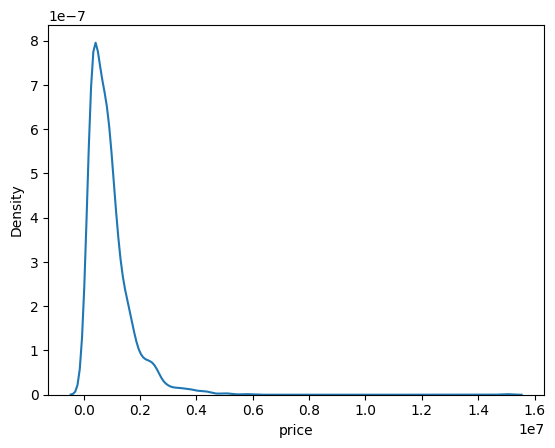

In [35]:
df_target = df["price"]
sns.kdeplot(df_target);

La target, el precio, no tiene una distribución normal, sino asimétrica derecha. Vamos a probar a realizar algunas transformaciones matemáticas, para ver si puedo normalizarla. 

Text(0.5, 1.0, 'Power 2')

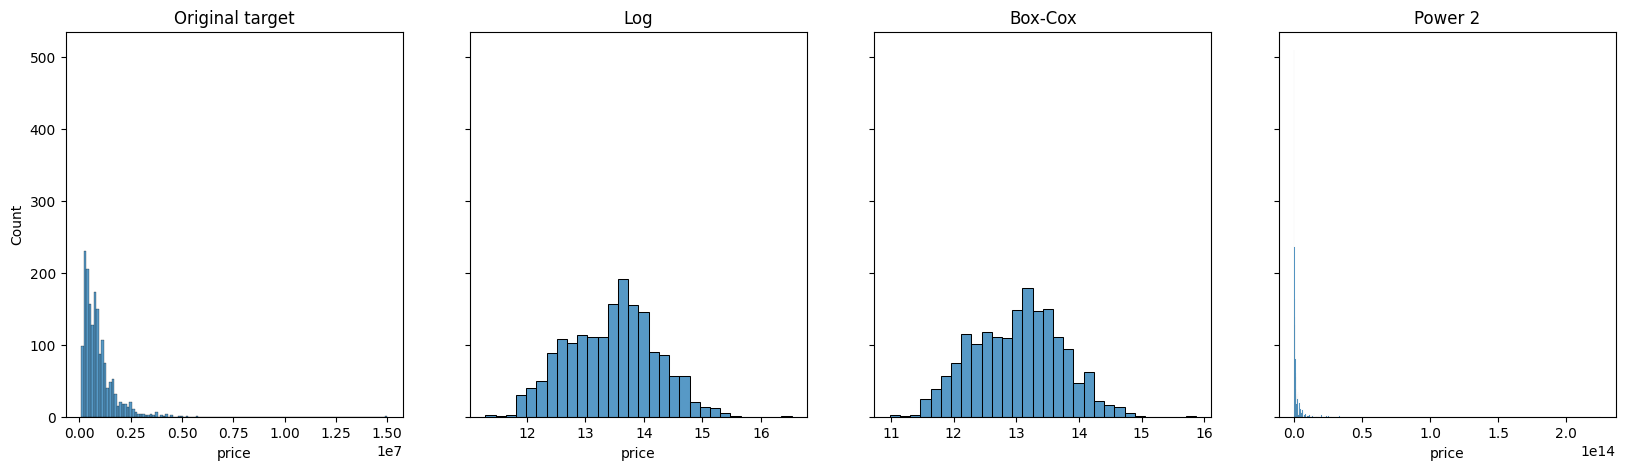

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# Original target
sns.histplot(df_target, kde=False, ax=axes[0])
axes[0].set_title("Original target")

# Logaritmic
sns.histplot(np.log(df_target),kde=False, ax=axes[1])
axes[1].set_title("Log")

# Box-cox
sns.histplot(stats.boxcox(df_target)[0],kde=False, ax=axes[2])
axes[2].set_title("Box-Cox");

# Power 2
sns.histplot(np.power(df_target, 2),kde=False, ax=axes[3])
axes[3].set_title("Power 2")

In [37]:
# Prueba de Shapiro-Wilk para cada transformación
shapiro_original = stats.shapiro(df_target)
shapiro_log = stats.shapiro(np.log(df_target))
shapiro_boxcox = stats.shapiro(stats.boxcox(df_target)[0])
shapiro_power2 = stats.shapiro(np.power(df_target, 2))

# Imprimir resultados
print(f"Shapiro-Wilk Test - Original: p-value = {shapiro_original.pvalue:.10f}")
print(f"Shapiro-Wilk Test - Log: p-value = {shapiro_log.pvalue:.10f}")
print(f"Shapiro-Wilk Test - Box-Cox: p-value = {shapiro_boxcox.pvalue:.10f}")
print(f"Shapiro-Wilk Test - Power 2: p-value = {shapiro_power2.pvalue:.10f}")


Shapiro-Wilk Test - Original: p-value = 0.0000000000
Shapiro-Wilk Test - Log: p-value = 0.0000006682
Shapiro-Wilk Test - Box-Cox: p-value = 0.0000006480
Shapiro-Wilk Test - Power 2: p-value = 0.0000000000


Todas las transformaciones tienen p-valores bajos (<0.05), significa que ninguna logra una normalidad perfecta, buscaremos el que tenga mayor p-valor.

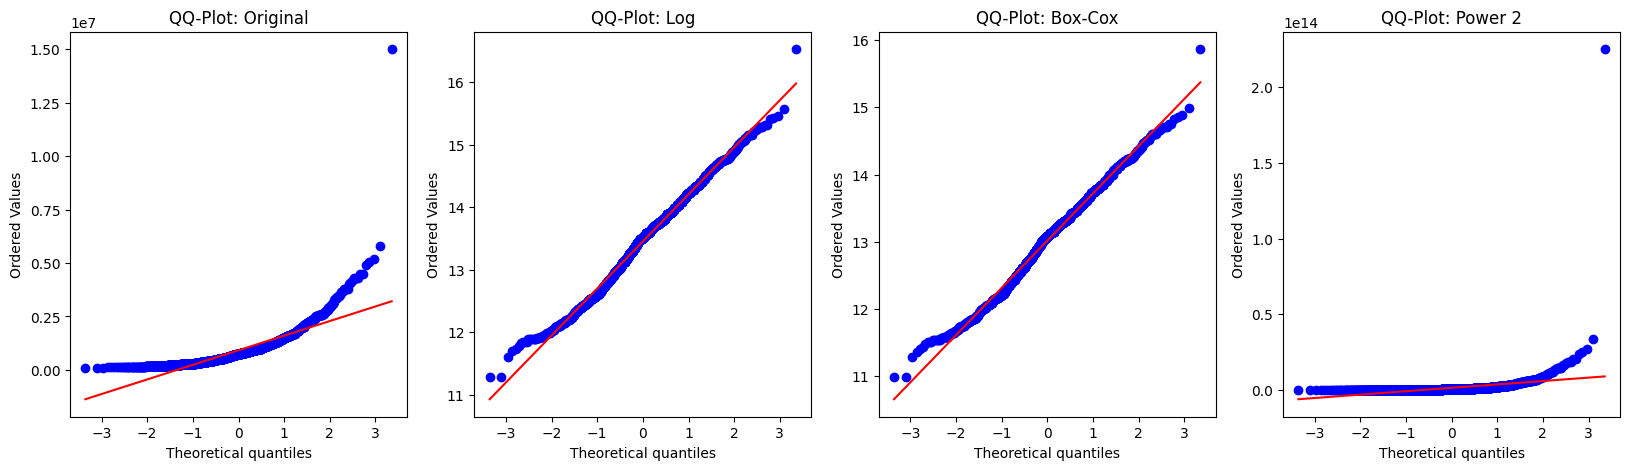

In [38]:
# Grafica Q-Q plot de cada una de las transformaciones
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
#  Original
stats.probplot(df_target, dist="norm", plot=axes[0])
axes[0].set_title("QQ-Plot: Original")

# Log
stats.probplot(np.log(df_target), dist="norm", plot=axes[1])
axes[1].set_title("QQ-Plot: Log")

# Box-Cox
stats.probplot(stats.boxcox(df_target)[0], dist="norm", plot=axes[2])
axes[2].set_title("QQ-Plot: Box-Cox")

# Power 2
stats.probplot(np.power(df_target, 2), dist="norm", plot=axes[3])
axes[3].set_title("QQ-Plot: Power 2")

plt.show()


Ninguna transformación logra una distribución normal, pero el logaritmo y box-cox logran resultados casi idénticos. Ante ambas opciones, sigo la elección más fácil de explicar, la transformación logarítmica. 

___________________________________________________________
Con estos pasos, paso al siguiente notebook donde realizaré y desarrollaré la fase de EDA, desde compresión de variables y analisis de los datos hasta reducción de dimensionalidad

#
[Ir al siguiente notebook: Análisis Exploratorio (EDA)](./02_Analisis_exploratorio.ipynb)
